In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_25488db3817e457b8f80835d2cf306ff = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='uPtCMVs7PBb8wTrgjMaUJxwVCGy2saFKun-UKda8SgkU',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')


body = client_25488db3817e457b8f80835d2cf306ff.get_object(Bucket='notebook-donotdelete-pr-padvjxp5mbtaje',Key='DTB3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df= pd.read_csv(body)
df.head()

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200224145614-0000
KERNEL_ID = c40e9c9f-9f25-4c0a-b3d8-c4e9845500d5


,DATE,DTB3
0,1954-01-04,1.330
1,1954-01-05,1.280
2,1954-01-06,1.280
3,1954-01-07,1.310
4,1954-01-08,1.310


In [3]:
print (df.shape)

(17254, 2)


In [2]:
df  = df [df.DTB3 !='.']
print (df.shape)

(16524, 2)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(df["DTB3"],color = 'red', label = '3-Monthly Tresury bill')
plt.title ('3-Monthly Tresury Bill')
plt.xlabel('Time (Days)')
plt.ylabel('Interst Rate')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import sequence

Using TensorFlow backend.


In [5]:
batch_size = 64
epochs = 5
timesteps  =10

In [8]:
length = len(df)
print (length)
print (length*0.9)

16524
14871.6


In [25]:
14871.0%64.0

23.0

In [9]:
def get_train_length(dataset, batch_size, test_percent):
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length)-100, int(length)):
        modulo = x%batch_size
        if (modulo ==0):
            train_length_values.append(x)
            print (x)
    return (max(train_length_values))

In [10]:
length = get_train_length(df, batch_size, 0.1)
print (length)

14784
14848
14848


In [11]:
upper_train = length + timesteps*2
df_data_1_train = df[0:upper_train]
trainning_set  = df_data_1_train.iloc[:,1:2].values
trainning_set.shape

(14868, 1)

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
trainning_set_scaled = sc.fit_transform(np.float64(trainning_set))
trainning_set.shape

(14868, 1)

In [13]:
x_train = []
y_train = []


print (length + timesteps)
for i in range(timesteps, length + timesteps):
    x_train.append(trainning_set_scaled[i-timesteps:i, 0 ])
    y_train.append(trainning_set_scaled[i:i+timesteps,0])
    
print (len(x_train))
print (len(y_train))

14858
14848
14848


In [14]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[1],1))
print (x_train.shape)
print (y_train.shape)

(14848, 10, 1)
(14848, 10, 1)


In [15]:
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [31]:
inputs_1_mae = Input(batch_shape=(batch_size, timesteps,1))
lstm_1_mae = LSTM(10,stateful = True, return_sequences = True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful = True, return_sequences = True)(lstm_1_mae)
output_1_mae = Dense(units =1)(lstm_2_mae)
regressor_mae = Model(inputs = inputs_1_mae, outputs = output_1_mae)
regressor_mae.compile(optimizer = 'adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 10, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 10, 10)              480       
_________________________________________________________________
lstm_4 (LSTM)                (64, 10, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [32]:
for i in range(epochs):
    print("Epoch:" + str(i))
    regressor_mae.fit(x_train, y_train, shuffle=False, epochs = 1, batch_size=batch_size)
    regressor_mae.reset_states()

Instructions for updating:
Use tf.cast instead.


Epoch:0
Epoch 1/1
14848/14848 [==============================] - 269s 18ms/step - loss: 0.0502
Epoch:1
Epoch 1/1
14848/14848 [==============================] - 277s 19ms/step - loss: 0.0393
Epoch:2
Epoch 1/1
14848/14848 [==============================] - 246s 17ms/step - loss: 0.0359
Epoch:3
Epoch 1/1
14848/14848 [==============================] - 389s 26ms/step - loss: 0.0360
Epoch:4
Epoch 1/1
14848/14848 [==============================] - 382s 26ms/step - loss: 0.0333


In [33]:
import h5py
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [17]:
import h5py
regressor_mae = Model("my_model_with_mae_30_ts.h5")

In [19]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [20]:
test_length = get_test_length(df, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

16340
16404
16468
16468
1600


In [21]:
print(upper_train, upper_test, len(df))

14868 16488 16524


In [22]:
df_data_1_test =df[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

In [23]:


#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
X_test.shape 

(1600, 10, 1)

In [37]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(1600, 10, 1)
(1600, 10)
(1590, 1)


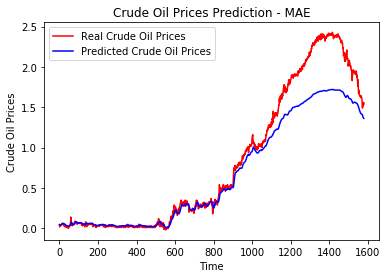

In [38]:
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Real Treasury Bill Market Rate')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Treasury Bill Market Rate')
plt.title('3-Monthly Treasury Bill Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Treasury Bill Market Rate')
plt.legend()
plt.show()

In [39]:

#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

0.2741841722141255


In [40]:

#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

0.2741841722141255


In [41]:

# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (64, 10, 1)               0         
_________________________________________________________________
lstm_5 (LSTM)                (64, 10, 10)              480       
_________________________________________________________________
lstm_6 (LSTM)                (64, 10, 10)              840       
_________________________________________________________________
dense_3 (Dense)              (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [42]:
from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

In [44]:
epochs = 5
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(x_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
14848/14848 [==============================] - 182s 12ms/step - loss: 0.0070
Epoch: 1
Epoch 1/1
14848/14848 [==============================] - 178s 12ms/step - loss: 0.0047
Epoch: 2
Epoch 1/1
14848/14848 [==============================] - 155s 10ms/step - loss: 0.0036
Epoch: 3
Epoch 1/1
14848/14848 [==============================] - 171s 12ms/step - loss: 0.0032
Epoch: 4
Epoch 1/1
14848/14848 [==============================] - 160s 11ms/step - loss: 0.0031


In [45]:
import h5py
regressor_mse.save(filepath="my_model_with_mse_30_ts.h5")

In [ ]:
regressor_mse = load_model(filepath="my_model_with_mse_30_ts.h5")

In [47]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

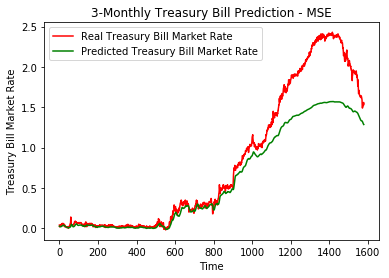

In [48]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Real Treasury Bill Market Rate')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Treasury Bill Market Rate')
plt.title('3-Monthly Treasury Bill Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Treasury Bill Market Rate')
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

0.34315153990165437


In [50]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(mean)

0.8148607594936708


In [51]:
rmse/mean * 100

42.11167808778497

In [52]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)

0.2113228554293716


In [53]:
mae/mean * 100

25.933615402057285

## Let's Try with 5 percent test_set

In [56]:
length = get_train_length(df, batch_size, 0.05)
print (length)

15616
15680
15680


In [57]:
upper_train = length + timesteps*2
df_data_1_train = df[0:upper_train]
trainning_set  = df_data_1_train.iloc[:,1:2].values
trainning_set.shape

(15700, 1)

In [58]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
trainning_set_scaled = sc.fit_transform(np.float64(trainning_set))
trainning_set.shape

(15700, 1)

In [59]:
x_train = []
y_train = []


print (length + timesteps)
for i in range(timesteps, length + timesteps):
    x_train.append(trainning_set_scaled[i-timesteps:i, 0 ])
    y_train.append(trainning_set_scaled[i:i+timesteps,0])
    
print (len(x_train))
print (len(y_train))

15690
15680
15680


In [60]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[1],1))
print (x_train.shape)
print (y_train.shape)

(15680, 10, 1)
(15680, 10, 1)


In [63]:
inputs_1_mae2 = Input(batch_shape=(batch_size, timesteps,1))
lstm_1_mae2 = LSTM(10,stateful = True, return_sequences = True)(inputs_1_mae2)
lstm_2_mae2 = LSTM(10, stateful = True, return_sequences = True)(lstm_1_mae2)
output_1_mae2 = Dense(units =1)(lstm_2_mae2)
regressor_mae2 = Model(inputs = inputs_1_mae2, outputs = output_1_mae2)
regressor_mae2.compile(optimizer = 'adam', loss = 'mae')
regressor_mae2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (64, 10, 1)               0         
_________________________________________________________________
lstm_9 (LSTM)                (64, 10, 10)              480       
_________________________________________________________________
lstm_10 (LSTM)               (64, 10, 10)              840       
_________________________________________________________________
dense_5 (Dense)              (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [64]:
for i in range(epochs):
    print("Epoch:" + str(i))
    regressor_mae2.fit(x_train, y_train, shuffle=False, epochs = 1, batch_size=batch_size)
    regressor_mae2.reset_states()

Epoch:0
Epoch 1/1
15680/15680 [==============================] - 155s 10ms/step - loss: 0.0720
Epoch:1
Epoch 1/1
15680/15680 [==============================] - 197s 13ms/step - loss: 0.0392
Epoch:2
Epoch 1/1
15680/15680 [==============================] - 237s 15ms/step - loss: 0.0299
Epoch:3
Epoch 1/1
15680/15680 [==============================] - 132s 8ms/step - loss: 0.0263
Epoch:4
Epoch 1/1
15680/15680 [==============================] - 380s 24ms/step - loss: 0.0246


In [65]:
import h5py
regressor_mae2.save(filepath="my_model_with_mae_30_ts2.h5")

In [ ]:
import h5py
regressor_mae2 = Model("my_model_with_mae_30_ts2.h5")

In [66]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [67]:
test_length = get_test_length(df, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

16340
16404
16468
16468
768


In [68]:
df_data_1_test =df[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values



#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [69]:
#prediction
predicted_bcg_values_test_mae = regressor_mae2.predict(X_test, batch_size=batch_size)
regressor_mae2.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(768, 10, 1)
(768, 10)
(758, 1)


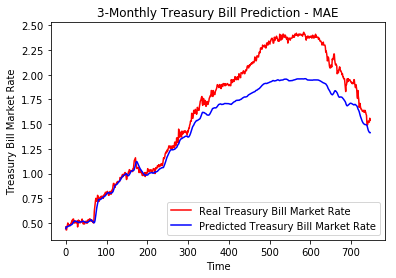

In [70]:
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Real Treasury Bill Market Rate')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Treasury Bill Market Rate')
plt.title('3-Monthly Treasury Bill Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Treasury Bill Market Rate')
plt.legend()
plt.show()

In [71]:

#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

0.2392276429812747


In [72]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

0.2392276429812747


In [74]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse2 = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse2 = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse2)
lstm_2_mse2 = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse2)

output_1_mse2 = Dense(units = 1)(lstm_2_mse2)

regressor_mse2 = Model(inputs=inputs_1_mse2, outputs = output_1_mse2)

#mse -> mean squared error as loss function
regressor_mse2.compile(optimizer='adam', loss = 'mse')
regressor_mse2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (64, 10, 1)               0         
_________________________________________________________________
lstm_13 (LSTM)               (64, 10, 10)              480       
_________________________________________________________________
lstm_14 (LSTM)               (64, 10, 10)              840       
_________________________________________________________________
dense_7 (Dense)              (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [75]:
from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

In [76]:
epochs = 5
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse2.fit(x_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse2.reset_states()

Epoch: 0
Epoch 1/1
15680/15680 [==============================] - 414s 26ms/step - loss: 0.0051
Epoch: 1
Epoch 1/1
15680/15680 [==============================] - 381s 24ms/step - loss: 0.0029
Epoch: 2
Epoch 1/1
15680/15680 [==============================] - 401s 26ms/step - loss: 0.0024
Epoch: 3
Epoch 1/1
15680/15680 [==============================] - 373s 24ms/step - loss: 0.0021
Epoch: 4
Epoch 1/1
15680/15680 [==============================] - 393s 25ms/step - loss: 0.0020


In [77]:
import h5py
regressor_mse2.save(filepath="my_model_with_mse_30_ts2.h5")

In [78]:
regressor_mse2 = load_model(filepath="my_model_with_mse_30_ts2.h5")

NameError: name 'load_model' is not defined

In [79]:
predicted_bcg_values_test_mse = regressor_mse2.predict(X_test, batch_size=batch_size)
regressor_mse2.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

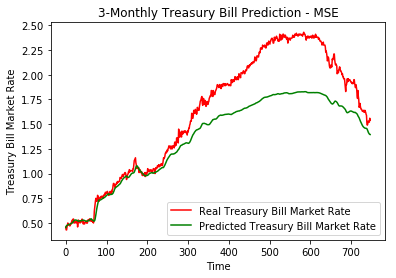

In [80]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Real Treasury Bill Market Rate')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Treasury Bill Market Rate')
plt.title('3-Monthly Treasury Bill Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Treasury Bill Market Rate')
plt.legend()
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

0.3242567415702007


In [82]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(mean)

1.6005882352941174


In [83]:
rmse/mean * 100

20.258598334044148

In [84]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)

0.2513554978498163


In [85]:
mae/mean * 100

15.703945106383232